# Tópicos

1. Working with data

2. Criando modelos

3. Otimizando parâmetros do modelo

4. Salvando modelos

5. Carregando modelos

6. Visualizando Imagens

7. Observando múltiplos dados

# Working with data

PyTorch contém datasets integrados para aprendizado inicial

Dataset usando para tutorial: FashionMNIST

```torchvision.datasets```contem ```Dataset``` para datasets de visão computacional, como CIFAR, COCO.

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

O dataset é passado no argumento da função ```DataLoader```para criar objeto iterável para

1. **batching**: subconjunto de dados de treinamento que é usado em uma única iteração de um algoritmo de otimização, como gradiente descendente

    Principais modos de batch:

    * Full-batch: O tamanho do lote é igual ao tamanho total do conjunto de dados
    * Modo Mini-Batch: O tamanho do lote é maior que 1, mas menor que o conjunto de dados total
    * Stochastic: O tamanho do lado é 1

    Batches menores tendem a introduzir mais ruído no processo de otimização, o que pode ajudar a rede a escapar de mínimos locais e encontrar soluções melhores, mas leva a convergência mais lenta

    Batches maiores resultam em uma estimativa de gradiente mais precisa, permitindo que a rede avance mais rapidamente em direção a um mínimo mas podem ficar presos em mínimos locais e exigem mais memória

2. **Sampling**: Técnica mais ampla que preocupa com a composição da amostra para garantir que o subconjunto de dados seja representativo do conjunto de dados total.

    Principais modos de sampling:

    * Amostragem aleatória: Subconjunto de dados complementares aleatórios
    * Amostragem estratificada: Criação de subgrupos com características comuns e, então, amostras são coletadas de cada subgrupo para formar um subconjunto. Útil com amostras desbalanceadas, como, por exemplo, detecção de fraudes (classe minoritária é preservada na amostra).
    * Sobreamostragem e subamostragem: Técnica para conjuntos desbalanceados. A sobreamostragem aumenta o número de exemplos de classe minoritária, enquanto a subamostragem reduz o número de exemplos de classe majoritária.

3. **shuffling**: Técnica para randomizar a ordem dos dados de treinamento antes ou durante de cada época. O objetivo é evitar que o modelo aprenda padrões baseados na ordem que os dados são apresentados.

4. **multiprocess**: Paralelização do trinamento

No exemplo, o batch size é definido com o valor de 64, de forma que cada elemento iterável no DataLoader retornará um batch de 64 elementos.

In [12]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f'Tamanho do conjunto de treino: {len(train_dataloader)}')
print(f'Tamanho do conjunto de teste: {len(test_dataloader)}')

# X recebe um batch (64 elementos)
# y recebe um batch de 64 labels correspondentes aos dados em X
# break irá encerrar após a primeira iteração
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# N retorna 64 -> tamanho do batch
# C, H e W -> Dimensão para os dados, como canais de cor, altura e largura para dados de imagem

Tamanho do conjunto de treino: 938
Tamanho do conjunto de teste: 157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Criando Modelos

Modelos com PyTorch são criados com classes que herdam de ```n.Module```.

As camadas da rede são definidas na função ```__init__```e a forma que os dados passam pela rede na função ```forward```.

* ```nn.Flatten```converte uma imagem 2D para um array contínuo
* ```nn.Linear```aplicada uma transformação linear na entrada, usando pesos e limiares armazenados
* ```nn.ReLU``` ativações não lineares criam mapeamentos complexos entre as entradas e saídas. Elas são aplicadas após a transformação linear para introduzir não linearidades para judar a rede a aprender fenômenos diversos.

```ReLU(f(X) = max(0, x))```

* ```nn.Sequential``` é um container ordenado de módulos. Os dados são passados todos na mesma ordem definida

In [13]:
import torch
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Otimizando parâmetros do modelo

Para treinar o modelo, são necessários <u>Loss Function</u> e um <u>otimizador</u>

1. **Loss Function**: Função matemática que mede a diferença entre saída prevista de um modelo e o valor real. O principal objetivo é a minimização da função de perda.

    Principais tipos para Regressões:

    * **Mean Squared Error (MSE)**: Média do quadrado das diferenças entre os valores previstos e os valores reais.

        * Penaliza erros maiores de forma mais severa devido ao quadrado, tornando sensível a *outliers*.

    * **Mean Absolute Error (MAE)**: Calcula a média das diferenças absolutas entre os valores previstos e reais
        * Útil quando o conjunto de dados contém valores discrepantes que não devem influenciar o modelo

    * **Huber Loss**: Função de perda híbrida que combina MSE e MAE.
        * Útil quando há presença de *outliers* e é necessário bom equilíbrio

    Principais tipos para Classificações:

    * **Binary Cross-Entropy**: Mede a diferença entre a distribuição de probabilidade prevista pelo modelo e a distribuiçãoo real
        * Útil para classificação de duas classes, como detecção de *spam* pu *diagnóstico de doenças*.

    * **Categorical Cross-Entropy**: Extensão de Binary Cross-Entropy para problemas com mais de duas classes

    *  **Sparse Categorical Cross-Entropy**: Semelhante a categorical Cross-Entropy, mas usada quando os rótulos de classe são inteiros em vez de vetores one-hot encoded.

2. **Otimizadores**: São algoritmos para ajuste de parâmetros internos do modelo (Pesos e Vieses) para minimizar função de perda. Indicam qual a direção e com qual intensidade os parâmetros devem ser alterados a cada alteração.

    Principais otimizadores:

    * **SGD (Stochastic Gradient Decendent)**: Para cada mini-batch (subconjunto de um batch), o SGD calcula o gradiente da função de perda em relação aos parâmetros do modelo.
        * Útil com conjuntos de dados pequenos ou problemas menos complexos, onde a simplicidade e a eficiência computacional são prioritárias.

    * **SGC com Momento**: Adiciona um termo de momento que acelera a convergência na direção correta e reduz a oscilação.
        * Útil com modelos profundos, onde a complexidade da paisagem de perda pode dificultar a convergência para o SGD padrão.

    * **AdaGrad**: Adapta a taxa de aprendizado para cada parâmetro individualmente. Diminui a taxa de aprendizado para parâmetros com grandes gradientes e aumenta para aqueles com pequenos gradientes.
        * Útil com dados esparsos (por exemplo, dados de processamento de linguagem natural), onde alguns recursos são raros e outros são frequentes.

    * **RMSprop**: Similar ao AdaGrad, mas utiliza uma média móvel dos quadrados dos gradientes para evitar que a taxa de aprendizado diminua rapidamente.
        * Útil com dados não estacionários, onde os padrões de gradiente podem mudar ao longo do tempo. É frequentemente usado em redes neurais recorrentes (RNNs) e dados de séries temporais.

    * **Adam (Adaptative Moment Estimation)**: Um dos otimizadores mais populares. Combina as ideias de momento e adaptatividade para ajustar a taxa de aprendizado de forma eficiente.
        * Útil com grandes conjuntos de dados e redes neurais profundas e sem tempo para otimizar manualmente a taxa de aprendizado, já que o Adam ajusta as taxas de aprendizado para cada parâmetro.

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #Learning Rate

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299670  [   64/60000]
loss: 2.285933  [ 6464/60000]
loss: 2.260698  [12864/60000]
loss: 2.256478  [19264/60000]
loss: 2.226507  [25664/60000]
loss: 2.207043  [32064/60000]
loss: 2.214581  [38464/60000]
loss: 2.178691  [44864/60000]
loss: 2.170147  [51264/60000]
loss: 2.136353  [57664/60000]
Test Error: 
 Accuracy: 46.6%, Avg loss: 2.128926 

Epoch 2
-------------------------------
loss: 2.141726  [   64/60000]
loss: 2.129738  [ 6464/60000]
loss: 2.060747  [12864/60000]
loss: 2.080667  [19264/60000]
loss: 2.022586  [25664/60000]
loss: 1.965390  [32064/60000]
loss: 1.990624  [38464/60000]
loss: 1.906367  [44864/60000]
loss: 1.901297  [51264/60000]
loss: 1.835432  [57664/60000]
Test Error: 
 Accuracy: 61.3%, Avg loss: 1.829277 

Epoch 3
-------------------------------
loss: 1.861504  [   64/60000]
loss: 1.835541  [ 6464/60000]
loss: 1.700261  [12864/60000]
loss: 1.751600  [19264/60000]
loss: 1.640512  [25664/60000]
loss: 1.597228  [32064/600

# Salvando Modelos

Serializa o estado interno do modelo

In [18]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Carregando Modelos

Recria a estrutura do modelo

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Visualizando Imagem

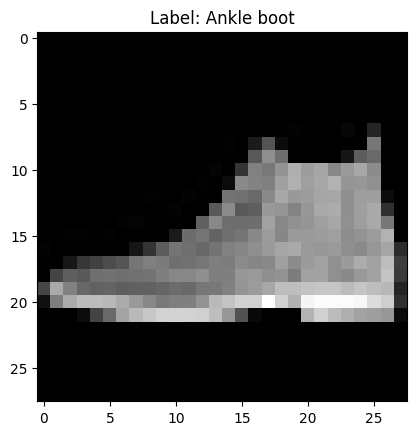

Formato da imagem: torch.Size([1, 28, 28])
Rótulo: 9


In [20]:
import matplotlib.pyplot as plt

class_names = training_data.classes
image, label = test_data[0]

# O tensor da imagem precisa ter a dimensão extra do canal de cor removida
# Antes de ser exibida com matplotlib
# A função .squeeze() faz isso
image_to_show = image.squeeze()

# Plotar a imagem
plt.imshow(image_to_show, cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.show()

# Imprimir o formato do tensor
print(f"Formato da imagem: {image.shape}")
print(f"Rótulo: {label}")